# **The Multiple Split Operator Fourier Transform (MSOFT) method**

**Authors:** Taylor Baird and Sara Bonella

<i class="fa fa-home fa-2x"></i><a href="../index.ipynb" style="font-size: 20px"> Go back to index</a>


**Source code:**  https://github.com/osscar-org/quantum-mechanics/blob/master/notebook/quantum-mechanics/msoft.ipynb

This notebook carries out the numerical solution of the 1D time-dependent Schrödinger equation for nuclear evolution on multiple electronic potential energy surfaces via the Multiple Split Operator Fourier Transform (MSOFT) method. 

<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

# **Goals**
* Understand the different steps in the MSOFT algorithm and how they are translated to code. 
* Familiarize yourself with the key assumptions underlying the algorithm and how their validity depends on the values of the parameters used in the simulation.
* Use the MSOFT algorithm to investigate the nonadiabatic dynamics of a nuclear wavepacket propagating in two different 2-level systems (a double harmonic potential and the Tully potential).

# **Background Theory**

[More in the background theory](./theory/theory_msoft.ipynb)

## **Tasks and exercises**

1. Investigate the dependence on timestep of the stability of the dynamics (try moving the slider for $dt$ and monitor the behaviour of the various control properties of the simulation).
    <details>
    <summary style="color: red">Solution</summary>
        One may observe that as the timestep employed in the simulation is increased, the conservation of total energy of the system degrades until eventually the timestep is so large that the dynamics becomes totally unstable. The reason why this integration scheme does not conserve total energy may be attributed to the non-commutativity of the split-operator propagator with the Hamiltonian. It is worth noting, however, that norm conservation is maintained even as one increases the timestep. This latter fact is due to the unitarity of the propagator in the split-operator scheme.
    </details>

2. What dictates the maximum size of the timestep that we can use for the MSOFT algorithm (consider the main assumptions/approximations that are made when formulating the propagation scheme for MSOFT).
    <details>
    <summary style="color: red">Solution</summary>
    Recall that the central approximation used in the derivation of the MSOFT propagation scheme is in the truncation of the (symmetric) Trotter product formula: $e^{A+B} = \lim\limits_{P \to \infty} (e^{\frac{B}{2P}}e^{\frac{A}{P}} e^{\frac{B}{2P}})^{P} \approx (e^{\frac{B}{2N}}e^{\frac{A}{N}} e^{\frac{B}{2N}})^{N}$ for $N$ sufficiently large. This approximation becomes more and more accurate the larger we make the value of $N$. In our specific case we have $e^{\frac{it}{\hbar} (\hat{T} + \hat{V} )}$ and we approximate this via the product $(e^{\frac{it}{2\hbar N_{\text{steps}}}\hat{V} }e^{\frac{it}{\hbar N_{\text{steps}}}\hat{T} } e^{\frac{it}{2\hbar N_{\text{steps}}}\hat{V} })^{N_{\text{steps}}}$ where $N_{\text{steps}}\cdot dt = t$. This approximation therefore becomes increasingly more accurate the larger $N_{\text{steps}}$ (or equivalently the smaller we make $dt$).
    </details>

3. Why is the use of the MSOFT algorithm unfeasible for larger systems (think about how much data is needed to represent the state of the system on a computer and how many operations are required to carry out the propagation)?
    <details>
    <summary style="color: red">Solution</summary>
    In order to implement the MSOFT algorithm on a computer it is necessary to discretize the nuclear wavefunction. To do so, we must introduce a grid of points that make up the space throughout which the wavefunction extends. Say that for each dimension of the grid we use $N$ grid points. For a system in $d$ dimensions, this means that we shall require $N^d$ points to represent the wavefunction of a single nucleus. Now, if we want to instead consider a system of say $n$ nuclei then we find that a total number of $N^{nd}$ grid points are required. In other words, the amount of data required to represent our system scales exponentially with increasing system size. Moreover, since we must loop over each of these grid points to carry out the time evolution of our system - the number of operations required also scales exponentially. This is what renders the MSOFT algorithm unsuitable for large systems.
    </details>

4. Investigate the effect of increasing the coupling strength between different electronic states on the evolution of the two state populations (vary the $C$ slider for each potential).
    <details>
    <summary style="color: red">Solution</summary>
        One can note that by increasing the value of $C$ the probability of inducing a transition of the nuclear wavepacket from one electronic potential energy surface to the other is modulated. You can trace this back to the equations of motion given in the theory section.
    </details>

<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

In [8]:
"""
Notebook demonstrating the use of the MSOFT algorithm for quantum dynamics.
"""
%matplotlib widget
import numpy as np
from math import pi
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft

from ipywidgets import Button, FloatSlider, HBox, VBox, Accordion, Label, IntProgress, Dropdown, Layout
from IPython.display import display, Markdown
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.ticker as ticker
from IPython.display import clear_output
from datetime import datetime

In [9]:
class MSOFT(object):
    """
    Class to encapsulate the various ingredients of the MSOFT method.
    x: real space grid
    psi_0: inital total wavefunction, including real and imaginary parts of both electronic states
    h: the potential in diabatic representation
    dt: the time interval
    hbar: the Plank constant (default value 1.0 as atomic unit)
    m: the mass (default value 2000 au)
    """
    
    def __init__(self, x, psi_0, h, dt, hbar=1.0, m = 1.0):
        self.N = len(x);
        self.hbar = hbar;
        self.m = m;
        
        dx = x[1] -x [0]; #real space grid spacing
        dk = (2*pi)/(self.N*dx); # reciprocal space grid spacing 
        
        self.x = x;
        self.dx = dx;
        self.dk = dk;
        self.t = 0.0;
        self.dt = dt;
        self.tot_steps=100000

#         self.tot_steps=int(1e3/self.dt)
        self.tarr=self.dt*np.arange(self.tot_steps)
        self.m = m;
        
        self.k_x = np.zeros(self.N)
        for sx in range(int(self.N/2)):
            self.k_x[sx]=2*pi*sx/(dx*self.N)
        for sx in range(int(self.N/2),self.N):
            self.k_x[sx]=2*pi*(sx-self.N)/(dx*self.N)

        self.psi_x = np.zeros((self.N,2), dtype=np.complex128) # two components (one for each electronic
        self.psi_k = np.zeros((self.N,2), dtype=np.complex128) # state)

        self.P1 = np.array([np.nan]*self.tot_steps) # to track populations of each 
        self.P2 = np.array([np.nan]*self.tot_steps) # electronic state
        
        self.ekint = np.array([np.nan]*self.tot_steps)
        self.epot  = np.array([np.nan]*self.tot_steps)

        self.psi_x = psi_0;
        self._periodic_bc()

        if callable(h):
            self.h = h(x) 
        else:
            self.h = h  
                
        # Diagonalize the diabatic coupling matrix here and store eigenvalues.
        self._init_pot_prop()
              
    def _init_pot_prop(self):
        
        LX=self.x[-1]
        self.u = np.zeros(shape=(self.N,2),dtype=np.complex128)
        self.E_eigvals = np.zeros((self.N,2))
        self.De = np.zeros(shape=(self.N,2,2))
        self.DeT = np.zeros(shape=(self.N,2,2))

        for i in range(self.N):
            self.E_eigvals[i][0] = (self.h[i][0][0]+self.h[i][1][1]+np.sqrt((self.h[i][0][0]-self.h[i][1][1])*(self.h[i][0][0]-self.h[i][1][1])+4.*self.h[i][0][1]*self.h[i][1][0]))/2.;
            self.E_eigvals[i][1] = (self.h[i][0][0]+self.h[i][1][1]-np.sqrt((self.h[i][0][0]-self.h[i][1][1])*(self.h[i][0][0]-self.h[i][1][1])+4.*self.h[i][0][1]*self.h[i][1][0]))/2.
            if(i<=self.N/2):
        #    /* 1st column = 1st eigenvector */
                self.De[i][0][0] = self.h[i][0][1]/(self.E_eigvals[i][0]-self.h[i][0][0]);
                self.De[i][1][0] = 1;
                norm_fac = np.sqrt(self.De[i][0][0]*self.De[i][0][0]+1.);
                self.De[i][0][0] /= norm_fac;
                self.De[i][1][0] /= norm_fac;
                #   /* 2nd column = 2nd eigenvector */
                self.De[i][0][1] = -self.De[i][1][0];
                self.De[i][1][1] = self.De[i][0][0]

            else:            
                self.De[i][0][1] = self.h[i][0][1]/(self.E_eigvals[i][1]-self.h[i][0][0]);
                self.De[i][1][1] = 1;
                norm_fac = np.sqrt(self.De[i][0][1]*self.De[i][0][1]+1.);
                self.De[i][0][1] /= norm_fac;
                self.De[i][1][1] /= norm_fac;
                
                self.De[i][1][0] = -self.De[i][0][1];
                self.De[i][0][0] = self.De[i][1][1];

            self.DeT[i][0][0] = self.De[i][0][0];
            self.DeT[i][1][1] = self.De[i][1][1];
            self.DeT[i][1][0] = self.De[i][0][1];
            self.DeT[i][0][1] = self.De[i][1][0];
        
            self.u[i][0] = np.exp(-0.5j*self.dt*self.E_eigvals[i][0])
            self.u[i][1] = np.exp(-0.5j*self.dt*self.E_eigvals[i][1])

        
    def _periodic_bc(self):
        self.psi_x[-1][0] = self.psi_x[0][0]
        self.psi_x[-1][1] = self.psi_x[0][1]

               
    def _half_pot_prop(self, ft=True):
        if ft == True:
     
            self.psi_x[:,0] = ifft(self.psi_k[:,0])
            self.psi_x[:,1] = ifft(self.psi_k[:,1])
        
        
        self.psi_x=np.einsum('ijk,ik->ij',self.De,self.psi_x)
        self.psi_x=self.psi_x*self.u
        self.psi_x=np.einsum('ijk,ik->ij',self.DeT,self.psi_x)


        self._periodic_bc()

    def _full_kinetic_prop(self):
        self.psi_k[:] = fft(self.psi_x[:],axis=0)
        self.psi_k[:] = self.psi_k[:]*np.exp(-1.0j*self.k_x**2*self.dt/(2.0*self.m))[:,np.newaxis]            
        
    def _get_kinetic_energy(self, Nsteps):
        #ke=0.5*(1./self.m)*sum(np.ravel(np.einsum('i,ik->ik',self.k_x**2,np.absolute(self.psi_k)**2)))*self.dk
        psi_k_0=fft(self.psi_x[:,0])/self.N
        psi_k_1=fft(self.psi_x[:,1])/self.N
        #ke=0.5*(1./self.m)*sum((np.conj(psi_k_0)*psi_k_0*self.k_x**2 + np.conj(psi_k_1)*psi_k_1*self.k_x**2 ))*(1/.self.N*self.dx)
        ke=0.
        for sx in range(self.N):
            k=self.k_x[sx]
            ke+= 0.5*(1./self.m)*(k**2)*(np.linalg.norm(psi_k_0[sx])**2 + np.linalg.norm(psi_k_1[sx])**2)
        ke*=(self.dx*self.N)
        # ke=0.5*(1./self.m)*sum((np.conj(psi_k[:,0])*psi_k[:,0]*self.k_x**2 + np.conj(psi_k[:,1])*psi_k[:,1]*self.k_x**2 ))*self.dk
        self.ekint[int(self.t/self.dt)] = np.real(ke)
        
    def _get_potential_energy(self, Nsteps):
        epot = sum(np.conj(self.psi_x[:,0])*self.h[:,0,0]*self.psi_x[:,0] + \
                        np.conj(self.psi_x[:,0])*self.h[:,0,1]*self.psi_x[:,1] + \
                        np.conj(self.psi_x[:,1])*self.h[:,1,0]*self.psi_x[:,0] + \
                       np.conj(self.psi_x[:,1])*self.h[:,1,1]*self.psi_x[:,1] )*self.dx
        self.epot[int(self.t/self.dt)] = np.real(epot)


    def _pop_states(self,Nsteps):
        # get the relative populations of each electronic state
        # no multiplication by dx b/c of definition of psi_x.
        pops = np.linalg.norm(self.psi_x,axis=0)**2
        self.P1[int(self.t/self.dt)] = pops[0] # interpolate populations
        self.P2[int(self.t/self.dt)] = pops[1] # between updates
        
    def _get_norm(self):
        self.norm = np.linalg.norm(self.psi_x)
             
    def evolution(self, Nsteps=1):

        for i in range(Nsteps):
            self._half_pot_prop(ft = False)
            self._full_kinetic_prop()         
            self._half_pot_prop(ft = True)
            
        self._get_kinetic_energy(Nsteps)
        self._get_potential_energy(Nsteps)
        self._pop_states(Nsteps)
        self._get_norm()
        self.t += self.dt*Nsteps        

In [10]:
def gauss_x(x, a, x0, k0):
    """
    a gaussian wave packet of width a, centered at x0, with momentum k0
    """
    gauss = np.exp(-1.*(x-x0)**2/(4.*a**2)) +0.j
    gauss*= np.exp(1.j*k0*(x-x0))
    return gauss/np.linalg.norm(gauss)

def double_harmonic(x,A,B,b,C,D):

    NX = len(x)
    h = np.zeros(shape=(NX,2,2))
   
    LX=x[-1]
    for sx,x_i in enumerate(x):
        
        h[sx][0][0] = A*(x_i-B)*(x_i-B)
        h[sx][0][1] = C*np.exp(-D*(x_i-0.5*LX)*(x_i-0.5*LX))
        h[sx][1][0] =  h[sx][0][1]
        h[sx][1][1] = A*(x_i-b)*(x_i-b)
        
    return h

def tully_pot(x,A,B,C,D):
   
    NX = len(x)
    h = np.zeros(shape=(NX,2,2))    
          
    for sx in range(NX):
        x_i = -0.5*LX+dx*sx
        
        h[sx][0][0] = A*(1.-np.exp(-B*abs(x_i)))*np.sign(x_i)
        h[sx][0][1] = C*np.exp(-D*x_i**2)
        h[sx][1][0] =  h[sx][0][1]
        h[sx][1][1] = -h[sx][0][0]
         
        if (sx==int(NX/2)):
            h[int(NX/2)][0][0] = 0.
            h[int(NX/2)][0][1] = C
            h[int(NX/2)][1][0] = C
            h[int(NX/2)][1][1] = 0. 
    return h

In [11]:
######################################################################
# Create the animation

# specify time steps and duration
dt = 0.25
N_steps = 50
t_max = 120
frames = int(t_max / float(N_steps * abs(dt)))

# Specify frequency at which observables are computed 
NECAL = 10
NNCAL = 1000

# specify constants
hbar = 1.0   # planck's constant
m = 2000.      # particle mass

# specify range in x coordinate
LX=50.
N=512
dx = LX/N
x = dx * np.arange(N)

# specify potential
A=0.001
B=20.
b=30.
C=0.005
D=1.0

# specify initial momentum and quantities derived from it
x0 = 19.0
p0 = 20.
s0 = 1.0
dp2 = p0 * p0 
d = hbar / np.sqrt(2 * dp2)

state_idx = 0
k0 = p0 / hbar
v0 = p0 / m
psi_x0 = np.zeros((N,2), dtype=np.complex128) # two components (one for each electronic state)
psi_x0[:,state_idx] = gauss_x(x, s0, x0, p0) # IC is a Gaussian wavepacket on 1st state and 0 component on second state


Accordion(children=(VBox(children=(Dropdown(description='Potential type:', options=('1. Double Harmonic', '2. …

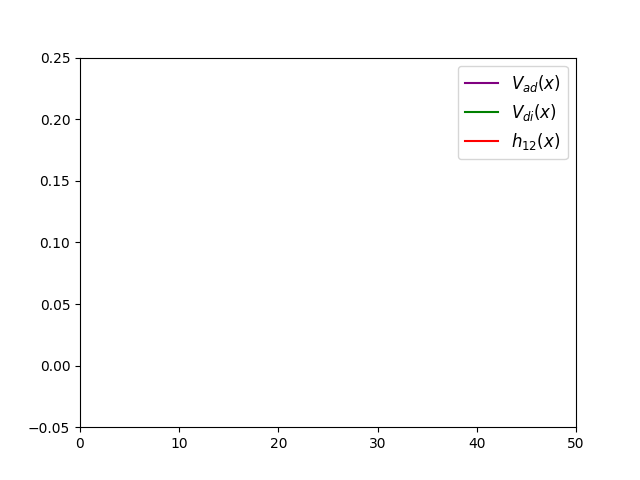

In [15]:
##################################################################################
# All code below this point relates to visualization and interactivity           #
# and can be ignored when considering only the specifics of the MSOFT algorithm. #
##################################################################################

style = {'description_width': 'initial'}

pot_select = Dropdown(
    options=['1. Double Harmonic', '2. Tully'],
    index = 0,
    description='Potential type:',
    disabled=False,
    style = style
)

state_select = Dropdown(
    options=['1', '2'],
    index = 0,
    description='Choose initial electronic state.',
    disabled=False,
    style = style
)

layout_hidden  = widgets.Layout(visibility = 'hidden')
layout_visible = widgets.Layout(visibility = 'visible')

# Set params of double harmonic PES (pot1)

s_dharm_A = FloatSlider(value = A, min = 0.0, max = 10.*A, step=0.001,readout_format='.5f', description = 'A: ')
s_dharm_B = FloatSlider(value = B, min = 0.0, max = 10.*B, description = 'B: ')
s_dharm_b = FloatSlider(value = b, min = 0.0, max = 10.*b, description = 'b: ')
s_dharm_C = FloatSlider(value = C, min = 0.0, max = 0.5, step=0.001, readout_format='.4f', description = 'C: ')
s_dharm_D = FloatSlider(value = D, min = 0.0, max = 10.*D, description = 'D: ')

s_dharm_A.layout = layout_visible
s_dharm_B.layout = layout_visible
s_dharm_b.layout = layout_visible
s_dharm_C.layout = layout_visible
s_dharm_D.layout = layout_visible

# Set params for Tully PES (pot2)

s_tully_A = FloatSlider(value = 0.01, min = 0.01, max = 0.25,step=0.01, description = 'A: ');
s_tully_B = FloatSlider(value = 1.6, min = 0.0, max = 3.2, description = 'B: ');
s_tully_C = FloatSlider(value = 0.005, min = 0.0, max = 0.05,step=0.001, description = 'C: ');
s_tully_D = FloatSlider(value = 1.0, min = 0.0, max = 10.0, description = 'D: ');


s_tully_A.layout = layout_hidden 
s_tully_B.layout = layout_hidden 
s_tully_C.layout = layout_hidden 
s_tully_D.layout = layout_hidden 

#Show the potential image
file1 = open("images/dharm_pot.png", "rb")
image1 = file1.read()
file2 = open("images/tully_potential.png", "rb")
image2 = file2.read()

pot_img = widgets.Image(
    value=image1,
    format='png',
    width=700,
    height=700,
)

    

pot_fig = plt.figure()
pot_ax=pot_fig.add_subplot()
pot_ax.set_ylim(-0.05,0.25)
pot_ax.set_xlim(0,50)


pot_prev_V1_ad_x_line, = pot_ax.plot([], [], c='purple', label=r'$V_{ad}(x)$')
pot_prev_V2_ad_x_line, = pot_ax.plot([], [], c='cyan')#, label=r'$V_{ad}(x)$')
pot_prev_V1_di_x_line, = pot_ax.plot([], [], c='green', label=r'$V_{di}(x)$')
pot_prev_V2_di_x_line, = pot_ax.plot([], [], c='green')#, label=r'$V_{di}(x)$')
pot_prev_V2_di_coupling_x_line, = pot_ax.plot([], [], c='red', label='$h_{12}(x)$')#, label=r'$V_{di}(x)$')

pot_leg= pot_ax.legend(prop=dict(size=12))

l = Layout(flex='0 1 auto', height='80px', min_height='40px', width='auto')
#pot_eqn=Label(value=r'\(h(x_i)=\begin{pmatrix} A(1-e^{-B|\frac{LX}{2}-x_i|})\cdot \text{sgn}(\frac{LX}{2}-x_i) & Ce^{-D(\frac{LX}{2}-x_i)^2} \\Ce^{-D(\frac{LX}{2}-x_i)^2} & -A(1-e^{-B|\frac{LX}{2}-x_i|})\cdot \text{sgn}(\frac{LX}{2}-x_i)\end{pmatrix}\)',layout=l)
pot_eqn=Label(value=r'\(h(x_i)=\begin{pmatrix} &\color{green} {A(x_i-B)^2} & \color{red}{Ce^{(-D(x_i-\frac{LX}{2})^2)}} \\&\color{red}{Ce^{(-D(x_i-\frac{LX}{2})^2)}} & \color{green}{A(x_i-b)^2}\end{pmatrix}\)',layout=l)


pot_img.layout = layout_visible

def pot_change(change):
    global h_x

    if pot_select.index == 0:
        s_dharm_A.layout = layout_visible
        s_dharm_B.layout = layout_visible
        s_dharm_b.layout = layout_visible
        s_dharm_C.layout = layout_visible
        s_dharm_D.layout = layout_visible
        s_tully_A.layout = layout_hidden 
        s_tully_B.layout = layout_hidden 
        s_tully_C.layout = layout_hidden 
        s_tully_D.layout = layout_hidden 
        #pot_img.layout = layout_visible
        pot_img.value = image1
        pot_eqn.value = r'\(h(x_i)=\begin{pmatrix} &\color{green} {A(x_i-B)^2} & \color{red}{Ce^{(-D(x_i-\frac{LX}{2})^2)}} \\&\color{red}{Ce^{(-D(x_i-\frac{LX}{2})^2)}} & \color{green}{A(x_i-b)^2}\end{pmatrix}\)'

        
    elif pot_select.index == 1:
      
        s_dharm_A.layout = layout_hidden
        s_dharm_B.layout = layout_hidden
        s_dharm_b.layout = layout_hidden
        s_dharm_C.layout = layout_hidden
        s_dharm_D.layout = layout_hidden
        s_tully_A.layout = layout_visible
        s_tully_B.layout = layout_visible
        s_tully_C.layout = layout_visible
        s_tully_D.layout = layout_visible
        # pot_img.layout = layout_visible
        pot_img.value = image2         
        pot_eqn.value=r'\(h(x_i)=\begin{pmatrix} \color{green}{A(1-e^{-B|\frac{LX}{2}-x_i|})\cdot \text{sgn}(\frac{LX}{2}-x_i)} & \color{red}{Ce^{-D(\frac{LX}{2}-x_i)^2}} \\\color{red}{Ce^{-D(\frac{LX}{2}-x_i)^2}} & \color{green}{-A(1-e^{-B|\frac{LX}{2}-x_i|})\cdot \text{sgn}(\frac{LX}{2}-x_i)}\end{pmatrix}\)'

        
        
def state_change(change):
    global state_idx
    if state_select.index==0:
        state_idx = 0
    else:
        state_idx = 1
    
state_select.observe(state_change, names='value', type='change');
pot_select.observe(pot_change, names='value', type='change');

def on_pot_update(event):
    global h_x, S
    if pot_select.index == 0:
        h_x = double_harmonic(x, s_dharm_A.value,s_dharm_B.value,s_dharm_b.value,s_dharm_C.value,s_dharm_D.value)
    else:
        h_x = tully_pot(x,s_tully_A.value, s_tully_B.value, s_tully_C.value, s_tully_D.value)
        ax1.set_ylim(-0.05,0.25)
        ax1.set_xlim(20,50)
        tot_time=1800.*(30/p0) # scale x-axis depending on momentum
        ax2.set_xlim(0,tot_time)
        ax3.set_xlim(0,tot_time)
        ax4.set_xlim(0,tot_time)
        
    # global S,h_x,p0,state_idx,pot_leg   
    # # two components (one for each electronic state)
    # psi_x0 = np.zeros((N,2), dtype=np.complex128) 
    # # default IC is a Gaussian wavepacket on 1st state and 0 component on second state but 
    # # user can choose the reverse of this.
    # psi_x0[:,state_idx] = gauss_x(x, s0, x0, p0) 
    S = MSOFT(x = x, dt = dt, psi_0=psi_x0, h=h_x, hbar=hbar, m=m)
    
    # pot_ax.clear()
    # pot_leg.remove()

    # pot_ax.get_legend().remove()
    # pot_prev_V1_ad_x_line, = pot_ax.plot(S.x, S.E_eigvals[:,0], c='purple', label=r'$V_{ad}(x)$')
    # pot_prev_V2_ad_x_line, = pot_ax.plot(S.x, S.E_eigvals[:,1], c='cyan')#, label=r'$V_{ad}(x)$')
    # pot_prev_V1_di_x_line, = pot_ax.plot(S.x, S.h[:,0,0], c='green', label=r'$V_{di}(x)$')
    # pot_prev_V2_di_x_line, = pot_ax.plot(S.x, S.h[:,1,1], c='green')#, label=r'$V_{di}(x)$')
#     pot_prev_V2_di_coupling_x_line, = pot_ax.plot(S.x,S.h[:,1,0], c='red', label='$h_{12}(x)$')#, label=r'$V_{di}(x)$')
    # pot_ax.legend()
    pot_prev_V2_di_coupling_x_line.set_data(S.x,S.h[:,1,0])#, label=r'$V_{di}(x)$')

    pot_prev_V1_ad_x_line.set_data(S.x, S.E_eigvals[:,0])#, c='purple', label=r'$V_{ad}(x)$')
    pot_prev_V2_ad_x_line.set_data(S.x, S.E_eigvals[:,1])#,c='purple')
    pot_prev_V1_di_x_line.set_data(S.x, S.h[:,0,0])#, c='green', label=r'$V_{di}(x)$')
    pot_prev_V2_di_x_line.set_data(S.x, S.h[:,1,1])#,c ='green')
#     pot_prev_V2_di_coupling_x_line.set_data(S.x,0.1*np.ones(len(S.h)))#,  c='red', label='$h_{12}(x)$')
    S.evolution(1)


pot_update = Button(description="Update potential")
pot_update.on_click(on_pot_update)

# The accordion for the potential
label1 = Label("(Press update potential and then update parameters to modify the potential.)")
pot_accordion = Accordion(children=[VBox([pot_select, pot_eqn, state_select,
                   HBox([s_dharm_A,s_dharm_B,s_dharm_b,s_dharm_C,s_dharm_D]),
                   HBox([s_tully_A,s_tully_B,s_tully_C,s_tully_D]),
                   HBox([pot_update, label1])])], selected_index = None)

pot_accordion.set_title(0, "Select potential and set parameters")
display(pot_accordion)


In [13]:
w_mass = FloatSlider(value = 2000, min = 0.0, max=5000, description="mass: ") 
w_dt = FloatSlider(value = 0.25, min = 0.001, max = 100.0, step=0.01, description="dt: ")
w_p0 = FloatSlider(value = 20.0, min = 7.5, max = 30.0, step=0.5, description="p0: ")

def on_mass_change(change):
    global m
    m = w_mass.value;
    
def on_dt_change(change):
    global dt
    dt = w_dt.value;
    
def on_p0_change(change):
    global p0
    p0 = w_p0.value;
    
def on_init_change(b):
    global S,h_x,p0,state_idx,pot_leg   
    # two components (one for each electronic state)
    psi_x0 = np.zeros((N,2), dtype=np.complex128) 
    # default IC is a Gaussian wavepacket on 1st state and 0 component on second state but 
    # user can choose the reverse of this.
    psi_x0[:,state_idx] = gauss_x(x, s0, x0, p0) 
    S = MSOFT(x = x, dt = dt, psi_0=psi_x0, h=h_x, hbar=hbar, m=m)
    
    # pot_ax.clear()
    # pot_leg.remove()

    # pot_ax.get_legend().remove()
    # pot_prev_V1_ad_x_line, = pot_ax.plot(S.x, S.E_eigvals[:,0], c='purple', label=r'$V_{ad}(x)$')
    # pot_prev_V2_ad_x_line, = pot_ax.plot(S.x, S.E_eigvals[:,1], c='cyan')#, label=r'$V_{ad}(x)$')
    # pot_prev_V1_di_x_line, = pot_ax.plot(S.x, S.h[:,0,0], c='green', label=r'$V_{di}(x)$')
    # pot_prev_V2_di_x_line, = pot_ax.plot(S.x, S.h[:,1,1], c='green')#, label=r'$V_{di}(x)$')
    # pot_prev_V2_di_coupling_x_line, = pot_ax.plot(S.x,S.h[:1,0], c='red', label='$h_{12}(x)$')#, label=r'$V_{di}(x)$')
    # pot_ax.legend()
    pot_prev_V1_ad_x_line.set_data(S.x, S.E_eigvals[:,0])#, c='purple', label=r'$V_{ad}(x)$')
    pot_prev_V2_ad_x_line.set_data(S.x, S.E_eigvals[:,1])#,c='purple')
    pot_prev_V1_di_x_line.set_data(S.x, S.h[:,0,0])#, c='green', label=r'$V_{di}(x)$')
    pot_prev_V2_di_x_line.set_data(S.x, S.h[:,1,1])#,c ='green')
    #pot_prev_V2_di_coupling_x_line.set_data(S.x,0.1*np.ones(len(S.h)))#,  c='red', label='$h_{12}(x)$')
    S.evolution(1)

w_mass.observe(on_mass_change, names='value')
w_dt.observe(on_dt_change, names='value')
w_p0.observe(on_p0_change, names='value')
w_init = Button(description="Update parameters");
w_init.on_click(on_init_change)


label2 = Label("(Press update parameters to modify the simulation parameters.)")

para_accordion = Accordion(children=[VBox([HBox([w_mass, w_dt, w_p0]), 
                                           HBox([w_init, label2])])], 
                           selected_index = None)
para_accordion.set_title(0, "Set simulation parameters")
display(para_accordion)

Accordion(children=(VBox(children=(HBox(children=(FloatSlider(value=2000.0, description='mass: ', max=5000.0),…

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


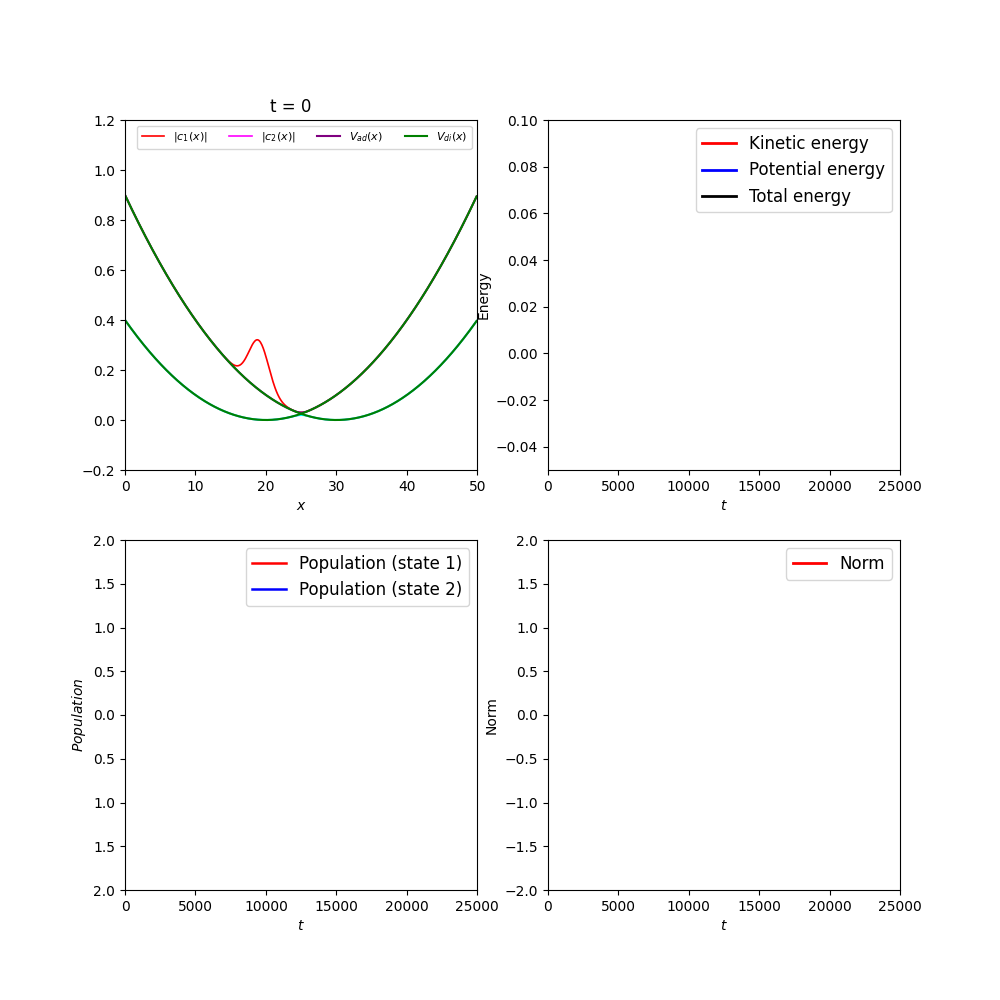

Button(description='Play', style=ButtonStyle())

Text(value='')

In [14]:
"""
The animation shall consist of the stationary plots of the potential in the adiabatic and diabatic picture 
along with the squared moduli of the components of the wavepackets on each of the potential energy surfaces.
"""

# set double harmonic potential as default
h_x = double_harmonic(x,A,B,b,C,D) 

S = MSOFT(x = x, dt = dt, psi_0=psi_x0, h=h_x, hbar=hbar, m=m)
S.evolution(1)

######################################################################
# Set up plot

fig = plt.figure(figsize=(10, 10))
fig.canvas.header_visible = False

# plotting limits
xlim = (0, 50)
tlim = (0,S.tot_steps)

ymin = 0.
if pot_select.index == 0:
    ymax = 1.0 
    ylims=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin))
else:
    xlim=(20,50)
    ylims=(-0.2,0.2)
    
ax1 = fig.add_subplot(221, xlim=xlim,
                      ylim=ylims)
psi1_x_line, = ax1.plot([], [], c='r', label=r'$|c_1(x)|$', linewidth=1.2)
psi2_x_line, = ax1.plot([], [], c='magenta', label=r'$|c_2(x)|$', linewidth=1.2)

V1_ad_x_line, = ax1.plot([], [], c='purple', label=r'$V_{ad}(x)$')
V2_ad_x_line, = ax1.plot([], [], c='cyan')#, label=r'$V_{ad}(x)$')
V1_di_x_line, = ax1.plot([], [], c='green', label=r'$V_{di}(x)$')
V2_di_x_line, = ax1.plot([], [], c='green')#, label=r'$V_{di}(x)$')



psi1_x_line.set_visible(True)
psi2_x_line.set_visible(True)

title = ax1.set_title("")
ax1.legend(prop=dict(size=8), ncol=4, loc=1)
ax1.set_xlabel('$x$')

ax2 = fig.add_subplot(223, xlim=(0,S.tot_steps*S.dt), ylim=(-2,2)) #axis for state populations
P1_line, = ax2.plot([], [], c='r', label=r'Population (state 1)', linewidth=1.8)
P2_line, = ax2.plot([], [], c='b', label=r'Population (state 2)', linewidth=1.8)

ax3 = fig.add_subplot(222, xlim=(0,S.tot_steps*S.dt),ylim=(-0.05,0.1)) # axis for energy plots
ax4 = fig.add_subplot(224, xlim=(0,S.tot_steps*S.dt), ylim=(-2,2)) # axis for norm plot

ax3.legend(prop=dict(size=12))
ax3.set_xlabel('$t$')
ax3.set_ylabel(r'Energy')
ke_line, = ax3.plot([], [], c='r', label=r'Kinetic energy', linewidth=2.0)
pe_line, = ax3.plot([], [], c='b', label=r'Potential energy', linewidth=2.0)
tot_e_line, = ax3.plot([], [], c='black', label=r'Total energy', linewidth=2.0)

ax3.legend(prop=dict(size=12))
ax4.set_xlabel('$t$')
ax4.set_ylabel(r'Norm')
norm_line, = ax4.plot([], [], c='r', label=r'Norm', linewidth=2.0)
ax4.legend(prop=dict(size=12))
ax2.legend(prop=dict(size=12))
ax2.set_xlabel('$t$')
ax2.set_ylabel(r'$Population$')

V1_ad_x_line.set_data(S.x, S.E_eigvals[:,0])
V2_ad_x_line.set_data(S.x, S.E_eigvals[:,1])
V1_di_x_line.set_data(S.x, S.h[:,0,0])
V2_di_x_line.set_data(S.x, S.h[:,1,1])

pot_prev_V1_ad_x_line.set_data(S.x, S.E_eigvals[:,0])
pot_prev_V2_ad_x_line.set_data(S.x, S.E_eigvals[:,1])
pot_prev_V1_di_x_line.set_data(S.x, S.h[:,0,0])
pot_prev_V2_di_x_line.set_data(S.x, S.h[:,1,1])
pot_prev_V2_di_coupling_x_line.set_data(S.x, S.h[:,1,0])


psi1_x_line.set_data(S.x, 1. * abs(S.psi_x[:,0])+S.E_eigvals[:,0])
psi2_x_line.set_data(S.x, 1. * abs(S.psi_x[:,1])+S.E_eigvals[:,1])

current_step = int(S.t/S.dt)
P1_mask = np.isfinite(S.P1) # masks for plotting intermittant data
P2_mask = np.isfinite(S.P2)

P1_line.set_data(S.tarr[P1_mask], S.P1[P1_mask])
P2_line.set_data(S.tarr[P2_mask], -1.*S.P2[P2_mask])

norm = np.sqrt(S.P1+S.P2)
norm_mask = np.isfinite(norm)
norm_line.set_data(S.tarr[norm_mask], norm[norm_mask])
ke_mask = np.isfinite(S.ekint)
ke_line.set_data(S.tarr[ke_mask], S.ekint[ke_mask])

pe_mask = np.isfinite(S.epot)
pe_line.set_data(S.tarr[pe_mask], S.epot[pe_mask])
tot_e_line.set_data(S.tarr[pe_mask], S.epot[pe_mask]+S.ekint[ke_mask])

# relabelling population graph axis to reflect positive populations
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(-x) if x < 0 else str(x)
    return label
ax2.yaxis.set_major_formatter(major_formatter)

title.set_text("t = %-5i" % S.t)
plt.show()

######################################################################
# Functions to Animate the plot

pause = True

def init():
    # pot_prev_V1_ad_x_line.set_data([],[])
    # pot_prev_V2_ad_x_line.set_data([],[])
    # pot_prev_V1_di_x_line.set_data([],[])
    # pot_prev_V2_di_x_line.set_data([],[])
    # pot_prev_V2_di_coupling_x_line.set_data([],[])
    psi1_x_line.set_data([], [])
    psi2_x_line.set_data([], [])
    V1_ad_x_line.set_data([],[])
    V2_ad_x_line.set_data([],[])
    V1_di_x_line.set_data([],[])
    V2_di_x_line.set_data([],[])
    
    P1_line.set_data([], [])
    P2_line.set_data([], [])
    
    ke_line.set_data([], [])
    pe_line.set_data([], [])

    norm_line.set_data([], [])   
    title.set_text("")
    
    return (psi1_x_line, psi2_x_line, V1_ad_x_line, P1_line, title)

def animate(i):
    
    global S,pause
    
    current_time = datetime.now()
    delta_time=(current_time-init_time).total_seconds()
    animation_dur = 50
    if not pause and (delta_time<60.0):

    # in the case of the double harmonic potential, if the animation has proceeded
        # for longer than the duration of interest then restart it.
        if(((S.t/S.dt)+animation_dur) >= S.tot_steps):
            on_init_change(None)

        if(pot_select.index==1):
        # if considering the Tully potential, stop sim after wavepacket reaches end of region
        # of interest
            if(S.psi_x[-1][0] > 0.0005 or S.psi_x[-1][1] > 0.0005):
                on_init_change(None)
        
        S.evolution(animation_dur)
        
        V1_ad_x_line.set_data(S.x, S.E_eigvals[:,0])
        V2_ad_x_line.set_data(S.x, S.E_eigvals[:,1])
        V1_di_x_line.set_data(S.x, S.h[:,0,0])
        V2_di_x_line.set_data(S.x, S.h[:,1,1])
        
        psi1_x_line.set_data(S.x, abs(S.psi_x[:,0])+S.E_eigvals[:,0])
        psi2_x_line.set_data(S.x, abs(S.psi_x[:,1])+S.E_eigvals[:,1])
        
        current_step = int(S.t/S.dt)
        P1_mask = np.isfinite(S.P1)
        P2_mask = np.isfinite(S.P2)
        
        P1_line.set_data(S.tarr[P1_mask], S.P1[P1_mask])
        P2_line.set_data(S.tarr[P2_mask], -1.*S.P2[P2_mask])
     
        norm = np.sqrt(S.P1+S.P2)
        norm_mask = np.isfinite(norm)
        norm_line.set_data(S.tarr[norm_mask], norm[norm_mask])
        
        ke_mask = np.isfinite(S.ekint)
        ke_line.set_data(S.tarr[ke_mask], S.ekint[ke_mask])
        
        pe_mask = np.isfinite(S.epot)
        pe_line.set_data(S.tarr[pe_mask], S.epot[pe_mask])
        tot_e_line.set_data(S.tarr[pe_mask], S.epot[pe_mask]+S.ekint[ke_mask])

        norm_text.value="Norm: "+str(norm[norm_mask][-1])
        title.set_text("t = %-5i" % S.t)
        return (psi1_x_line, V1_ad_x_line, P1_line, title)
    else:
        pause=True
        button_pause.description = "Play"
        anim.event_source.stop()
        
def onClick(event):
    global pause
    global init_time
    init_time=datetime.now()
    pause ^= True
    if button_pause.description == "Pause":
        button_pause.description = "Play"
        anim.event_source.stop()
    else:
        button_pause.description = "Pause"
        anim.event_source.start()
        
init_time=datetime.now()


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=1, blit=True)
button_pause = Button(description="Play");
button_pause.on_click(onClick)
display(button_pause);
norm_text = widgets.Text()
display(norm_text)

<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

# Legend (How to use the interactive visualization)

## Interactive figures

The interactive figures consist of 4 subplots (clockwise from the top):
1. The main animation pane. This shows the evolution of the two components of the nuclear wavefunction (red and magenta curves) on their respective electronic potential energy surfaces (PESs). The potential energy surfaces are plotted in both the adiabatic (purple) and diabatic bases (green).

2. Plot of the kinetic, potential and total energies vs simulation timestep.

3. Evolution of the populations on the two different electronic PESs.

4. Evolution of the total norm of the nuclear wavepacket.

Below the plots there is also a display field indicating the current value of the norm of the total wavefunction.

## Controls

* The type of potential may be selected by first expanding the "Select potential and set parameters" drawer. The two options are: a double harmonic potential and a Tully model potential.
* One can choose on which electronic state the Gaussian nuclear wavepacket is initialized by using the "Choose initial electronic state" dropdown.
* The parameters of each potential may be varied using the various sliders.
* To update the potential, the "Update potential" button should be pressed, followed by the "Update parameters" button in the "Set simulation parameters" drawer.

* The various simulation parameters (nuclear mass, timestep (dt), and initial momentum of the nuclear wavepacket (p0)) may be set using the sliders in the "Set simulation parameters" drawer.

